In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import abtem
import dask
import os
import sys
import importlib

#paths
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.abspath(os.path.join(parent_dir, 'data', 'data_phonons' ))
results_dir = os.path.abspath(os.path.join(parent_dir, 'results', 'images_lineprofiles_phonons'))

#import homemade modules by adding hBN_sim directory to sys.path
sys.path.insert(0, parent_dir)
import helper_funcs

#setting configuration
abtem.config.set({"device": "gpu", "fft": "fftw"})
dask.config.set({"num_workers": 1})

In [4]:
#reload when updating helper_funcs while working
importlib.reload(helper_funcs)

<module 'helper_funcs' from '/home/torchuser/data/evamaria/hBN_sim/helper_funcs.py'>

### RAW

In [25]:
#import preparation
data_names = [entry for entry in os.listdir(f'{data_dir}') if entry.endswith('.zarr')]
measurements_list = [None] * len(data_names)
#sort by timestamp
data_names.sort()

#fill measurements_list with imported data, sorted by timestamp (and therefore numconfigs ascending)
for i in range(len(data_names)):
    path = f'{data_dir}/{data_names[i]}'
    measurements_list[i] = abtem.from_zarr(path).compute()

[########################################] | 100% Completed | 1.64 sms
[########################################] | 100% Completed | 1.45 sms
[########################################] | 100% Completed | 1.45 sms
[########################################] | 100% Completed | 1.35 sms
[########################################] | 100% Completed | 1.55 sms
[########################################] | 100% Completed | 1.56 sms


In [7]:
len(measurements_list)
data_names[0]

'20240904162454_hBN_size20x13_single_vacanyB_filledwithO_energy60000_numconfigs5_Cs-100000_astig0_astigangle0_coma0_RAW.zarr'

In [8]:
#extract parameter information --> see data_names[0] for correct indices
#parameter_info = ["_".join([string.split('_')[0], (string.split('_')[7]).lstrip('filledwith')]) for string in data_names[:]]
parameter_info = [string.split('_')[7] for string in data_names[:]]

parameter_info

['numconfigs5',
 'numconfigs10',
 'numconfigs15',
 'numconfigs20',
 'numconfigs25',
 'numconfigs30']

(20.0, 30.0)

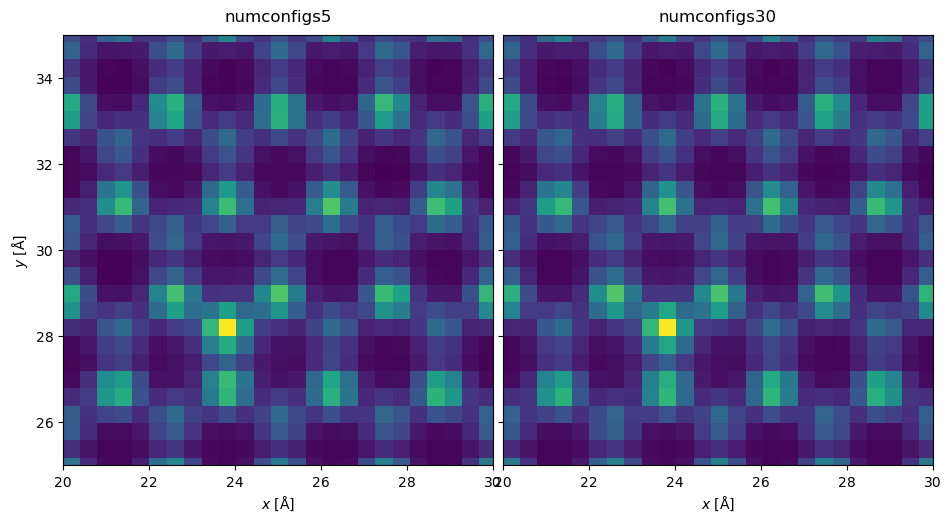

In [9]:
#plot
measurements = abtem.stack([m for m in measurements_list], parameter_info)
measurements[::5].show(figsize=(14, 5), explode=True, cbar=False,common_color_scale=True)

plt.ylim(25,35)
plt.xlim(20,30)

### INTERPOLATED + GAUSS

In [11]:
#set parameters for postprocessing
#pairs: interpolate:0.01 & gauss: 0.2;  interpolate:0.05 & gauss: 0.3
#interpolate-> higher value (0.1) more pixels; low value -> smoother, more time
interpolate = 0.01
gauss = 0.3

In [12]:
#interpolate to smooth images and apply gaussian filter to consider partial spatial coherence 
final_measurements = measurements.interpolate(interpolate).gaussian_filter(gauss)

(20.0, 30.0)

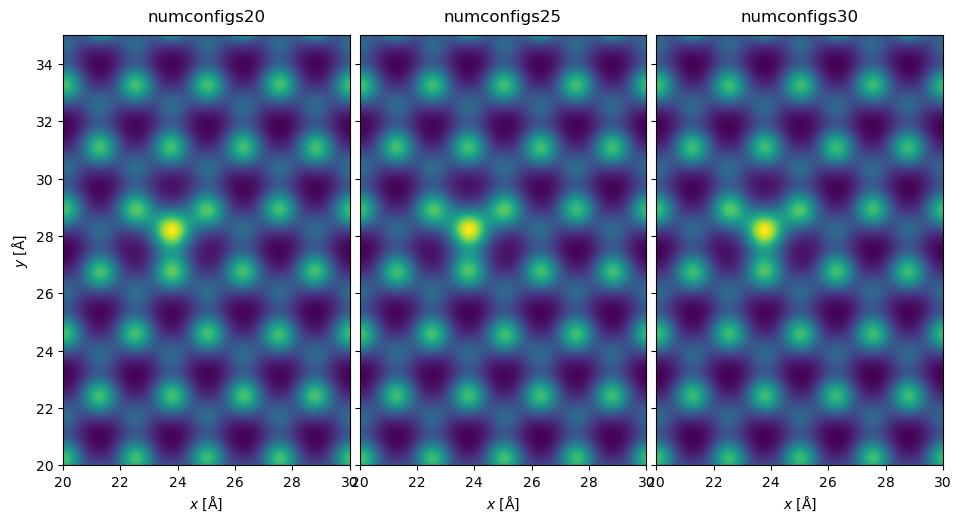

In [13]:
#plot
final_measurements_plot = abtem.stack(final_measurements, parameter_info)
final_measurements_plot[-3:].show(explode=True, figsize=(14, 5), cbar=False, common_color_scale=False)

plt.ylim(20,35)
plt.xlim(20,30)

### LINEPROFILES

In [16]:
#set parameters
lattice_constant = 2.504

#CHOOSE
center_x = 23.8 #center of defect atom: 23.8
center_y = 28.2 #center of defect atom:28.2
extent = 10 #length of line profile (Å)
angle = 30 # angle of line profile

#preparation for plot of line profile with flexible angle
x_angle = np.cos(angle * np.pi/180)*extent/2
y_angle = np.sin(angle * np.pi/180)*extent/2

(21.0, 27.0)

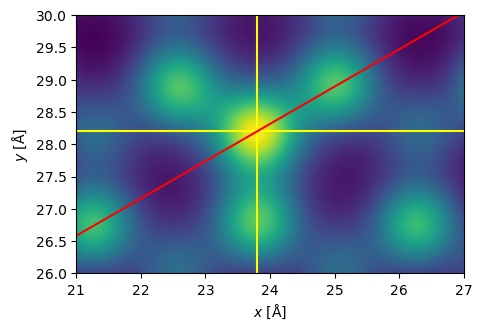

In [19]:
#visualization of parameter-set
fig_ang0, ax = plt.subplots(figsize=(5,5))
final_measurements_plot[0].show(ax=ax, explode=False, figsize=(14, 5), cbar=False, common_color_scale=False)

#plot yellow reference lines
line_ang0 = lines.Line2D([center_x - extent/2, center_x + extent/2,], [center_y, center_y], color='yellow')
line_ang0_y = lines.Line2D([center_x, center_x,], [center_y - extent/2, center_y + extent/2], color='yellow')

ax.add_line(line_ang0)
ax.add_line(line_ang0_y)

#plot red line along which the line profile will be calculated
line_ang = lines.Line2D([center_x - x_angle, center_x + x_angle], [center_y - y_angle, center_y + y_angle], color='red')

ax.add_line(line_ang)

plt.ylim(26,30)
plt.xlim(21,27)

In [20]:
#calculate
line_profiles = final_measurements.interpolate_line_at_position(center=(center_x, center_y), angle=angle, extent=extent)
line_start = line_profiles.metadata.get('start')
line_end = line_profiles.metadata.get('end')

#### single plot

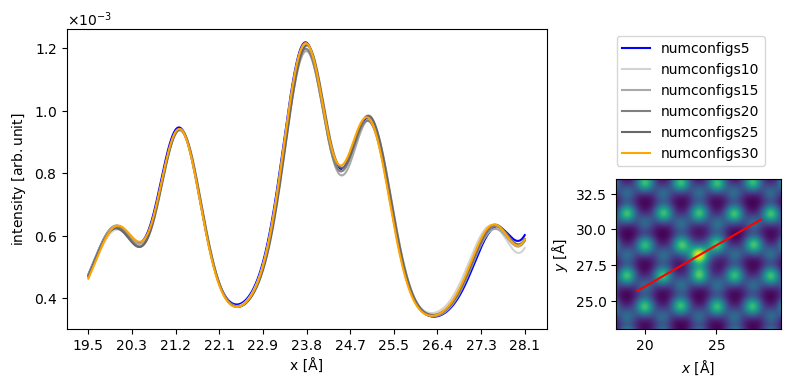

In [26]:
#plot settings - single plot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))

ax1.set_position([0.64, 0, 0.3, 0.3])#[x,y, width,height] -> all values [0:1]; fractions of figure
ax2.set_position([0, 0, 0.6, 0.6])
ax1.set_zorder(3)#holt kleinen plot in den Vordergrund
ax2.set_zorder(1)
x_ticks = [i for i in range(11)]
x_labels = np.around(np.linspace(line_start[0], line_end[0], 11),1)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_labels)

#fig.set_facecolor('khaki')

#atomic structure with line corresponding to line profiles
final_measurements_plot[0].show(ax=ax1, explode=False, figsize=(14, 5), cbar=False, common_color_scale=False)
line_ang = lines.Line2D([center_x - x_angle, center_x + x_angle], [center_y - y_angle, center_y + y_angle], color='red')
ax1.add_line(line_ang)
ax1.set_xlim(18,29.5)
ax1.set_ylim(23,33.5)

#mainplot: line profiles
color_list = ['blue', 'lightgrey', 'darkgrey', 'grey','dimgrey', 'orange']
for i in range(len(color_list)):
    line_profiles[i].show(ax=ax2, color=color_list[i], label=parameter_info[i])
ax2.legend(loc='upper right', bbox_to_anchor=(1.47, 1))
ax2.set_xlabel('x [Å]')

if line_start > line_end:
    ax2.invert_xaxis()
    
fig.figure.savefig(f'{results_dir}/test.png', bbox_inches='tight')

#### single plot: last n profiles

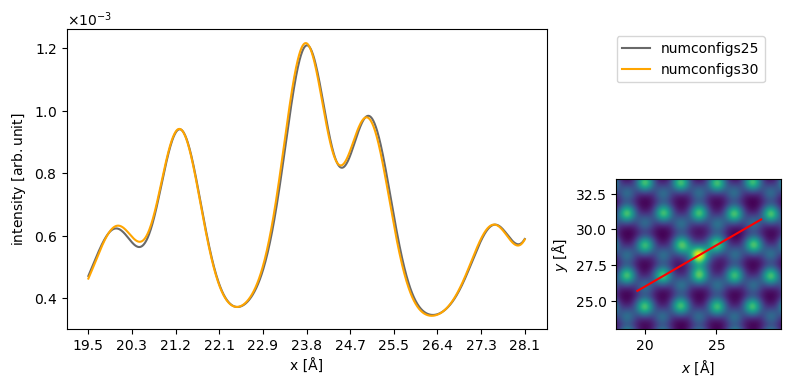

In [27]:
#plot settings - choose lineprofiles
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))
ax1.set_position([0.64, 0, 0.3, 0.3])#[abstand linker Rand, abstand rechter Rand, width(anteil der achse),height(anteil der achse)]
ax2.set_position([0, 0, 0.6, 0.6])
ax1.set_zorder(3)#holt kleinen plot in den Vordergrund
ax2.set_zorder(1)
x_ticks = [i for i in range(11)]
x_labels = np.around(np.linspace(line_start[0], line_end[0], 11),1)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_labels)

#fig.set_facecolor('khaki')

#atomic structure with line corresponding to line profiles
final_measurements_plot[0].show(ax=ax1, explode=False, figsize=(14, 5), cbar=False, common_color_scale=False)
line_ang = lines.Line2D([center_x - x_angle, center_x + x_angle], [center_y - y_angle, center_y + y_angle], color='red')
ax1.add_line(line_ang)
ax1.set_xlim(18,29.5)
ax1.set_ylim(23,33.5)

#show last n profiles
n = 2

#line profiles
color_list = ['blue', 'lightgrey', 'darkgrey', 'grey','dimgrey', 'orange']
for i in range(n):
    line_profiles[6-n+i].show(ax=ax2, color=color_list[6-n+i], label=parameter_info[6-n+i])
ax2.legend(loc='upper right', bbox_to_anchor=(1.47, 1))
ax2.set_xlabel('x [Å]')

if line_start > line_end:
    ax2.invert_xaxis()
    
#fig.figure.savefig(f'{results_dir}/test.png', bbox_inches='tight')

### overview plots

#### Overview: all 

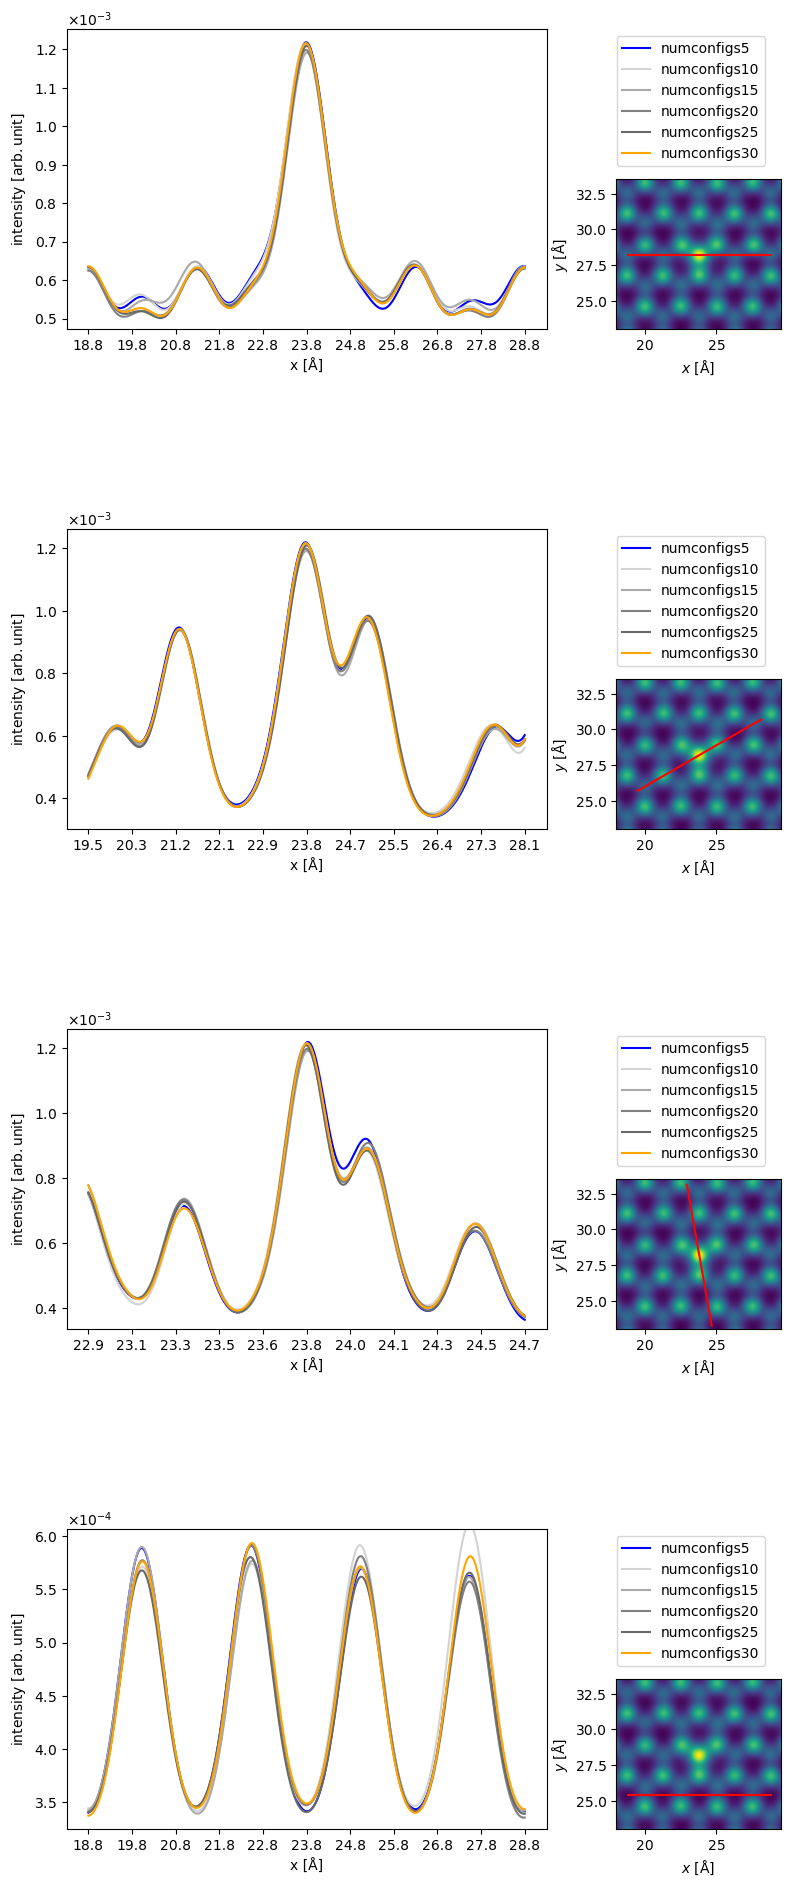

In [29]:
#set parameters

#CHOOSE ys and angles
center_y_list = [28.2, 28.2, 28.2, 25.4,] #defect: 28.2
angle_list = [0, 30, 100, 0]#each entry in the angle_list must correspond to a value in the center_y_list

#FIX
extent = 10
center_x = 23.8 #defect: 23.8
lattice_constant = 2.504
rows = len(angle_list)
subplot_x_size = 8 
subplot_y_size = 5

#plot
fig, axs = plt.subplots(rows, 2, figsize=(subplot_x_size,subplot_y_size*rows))

for row in range(rows):
    #create line profiles
    center_y = center_y_list[row]
    angle = angle_list[row]
    
    line_profiles = final_measurements.interpolate_line_at_position(center=(center_x, center_y), angle=angle, extent=extent)
    line_start = line_profiles.metadata.get('start')
    line_end = line_profiles.metadata.get('end')
    
    #preparation for plot of line profile with angle (degree)
    x_angle = np.cos(angle * np.pi/180)*extent/2
    y_angle = np.sin(angle * np.pi/180)*extent/2

    #plot settings & positioning
    ax1 = axs[row, 1]
    ax2 = axs[row, 0]
    traveling_y = (subplot_y_size*rows - subplot_y_size*(row+1))/(subplot_y_size*rows)
    ax1.set_position([0.64, traveling_y, 0.3, 0.3/rows])#[x,y, width,height] -> all values [0:1]
    ax2.set_position([0, traveling_y, 0.6, 0.6/rows])
    x_ticks = [i for i in range(11)]
    x_labels = np.around(np.linspace(line_start[0], line_end[0], 11),1)
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_labels)
        
    #atomic structure with line corresponding to line profiles
    final_measurements_plot[0].show(ax=ax1, explode=False, figsize=(14, 5), cbar=False, common_color_scale=False)
    line_ang = lines.Line2D([center_x - x_angle, center_x + x_angle], [center_y - y_angle, center_y + y_angle], color='red')
    ax1.add_line(line_ang)
    ax1.set_xlim(18,29.5)
    ax1.set_ylim(23,33.5)
    
    #mainplot: line profiles
    color_list = ['blue', 'lightgrey', 'darkgrey', 'grey','dimgrey', 'orange']
    for i in range(len(color_list)):
        line_profiles[i].show(ax=ax2, color=color_list[i], label=parameter_info[i])
    ax2.legend(loc='upper right', bbox_to_anchor=(1.47, 1))
    ax2.set_xlabel('x [Å]')

    #sometimes line profile is drawn from right to left. For easier understanding -> we invert image.
    if line_start > line_end:
        ax2.invert_xaxis()



fig.figure.savefig(f'{results_dir}/test.png', bbox_inches='tight')

#### Overview plots - last n profiles

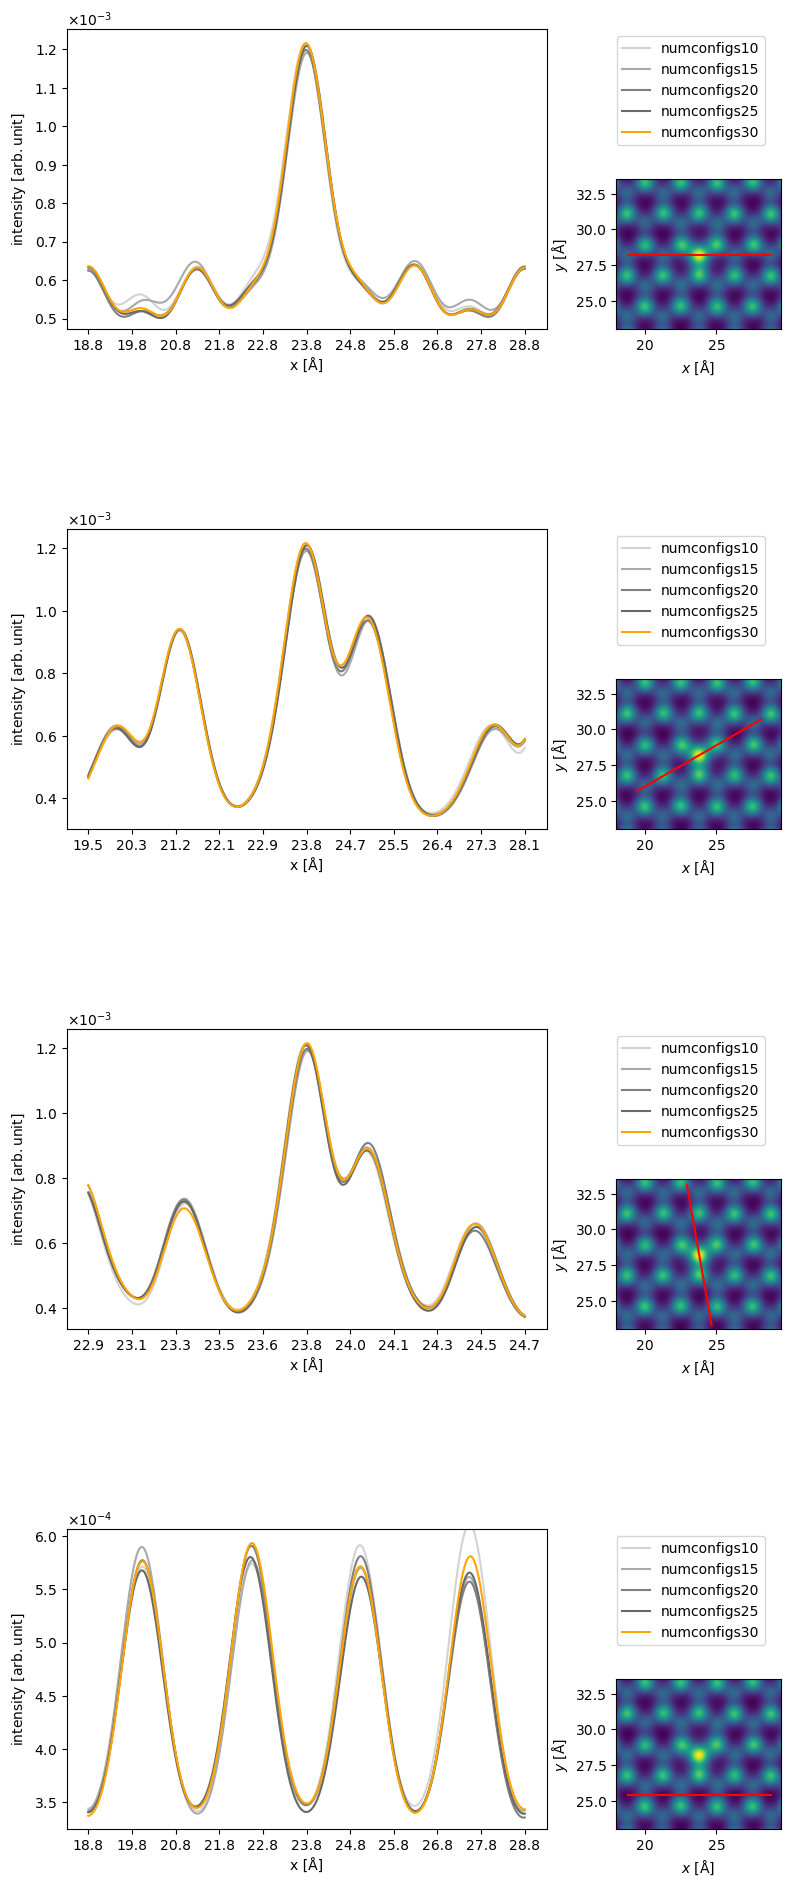

In [34]:
#set parameters - CHOOSE number of profiles

#CHOOSE
center_y_list = [28.2, 28.2, 28.2, 25.4,] #defect: 28.2
angle_list = [0, 30, 100, 0]#each entry in the angle_list must correspond to a value in the center_y_list
number_of_profiles = 5 #number of n last profiles

#FIX
center_x = 23.8 #defect: 23.8
extent = 10
lattice_constant = 2.504
rows = len(angle_list)
subplot_x_size = 8 
subplot_y_size = 5

#plot
fig, axs = plt.subplots(rows, 2, figsize=(subplot_x_size,subplot_y_size*rows))

for row in range(rows):
    #create line profiles
    center_y = center_y_list[row]
    angle = angle_list[row]
    n = number_of_profiles
    
    line_profiles = final_measurements.interpolate_line_at_position(center=(center_x, center_y), angle=angle, extent=extent)
    line_start = line_profiles.metadata.get('start')
    line_end = line_profiles.metadata.get('end')
    
    #preparation for plot of line profile with angle (degree)
    x_angle = np.cos(angle * np.pi/180)*extent/2
    y_angle = np.sin(angle * np.pi/180)*extent/2

    #plot settings
    #fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))
    ax1 = axs[row, 1]#fig.add_subplot(gs[row, 1])
    ax2 = axs[row, 0]#fig.add_subplot(gs[row, 0])

    traveling_y = (subplot_y_size*rows - subplot_y_size*(row+1))/(subplot_y_size*rows)
    ax1.set_position([0.64, traveling_y, 0.3, 0.3/rows])#[x,y, width,height] -> all values [0:1]
    ax2.set_position([0, traveling_y, 0.6, 0.6/rows])
    #ax1.set_zorder(3)#holt kleinen plot in den Vordergrund
    #ax2.set_zorder(1)
    x_ticks = [i for i in range(11)]
    x_labels = np.around(np.linspace(line_start[0], line_end[0], 11),1)
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_labels)
        
    #atomic structure with line corresponding to line profiles
    final_measurements_plot[0].show(ax=ax1, explode=False, figsize=(14, 5), cbar=False, common_color_scale=False)
    line_ang = lines.Line2D([center_x - x_angle, center_x + x_angle], [center_y - y_angle, center_y + y_angle], color='red')
    ax1.add_line(line_ang)
    ax1.set_xlim(18,29.5)
    ax1.set_ylim(23,33.5)
    
    #mainplot: line profiles
    color_list = ['blue', 'lightgrey', 'darkgrey', 'grey','dimgrey', 'orange']
    for i in range(n):
        line_profiles[6-n+i].show(ax=ax2, color=color_list[6-n+i], label=parameter_info[6-n+i])
    ax2.legend(loc='upper right', bbox_to_anchor=(1.47, 1))
    ax2.set_xlabel('x [Å]')

    #sometimes line profile is drawn from right to left. For easier understanding -> we invert image.
    if line_start > line_end:
        ax2.invert_xaxis()


fig.figure.savefig(f'{results_dir}/test.png', bbox_inches='tight')

### NOISE

In [32]:
#noise to account for finite electrone dose -> statistic deviation (see abtem walkthrough -> scan & detect)
dose = 1e9
noisy_measurements = final_measurements.poisson_noise(dose_per_area=dose, seed=100)


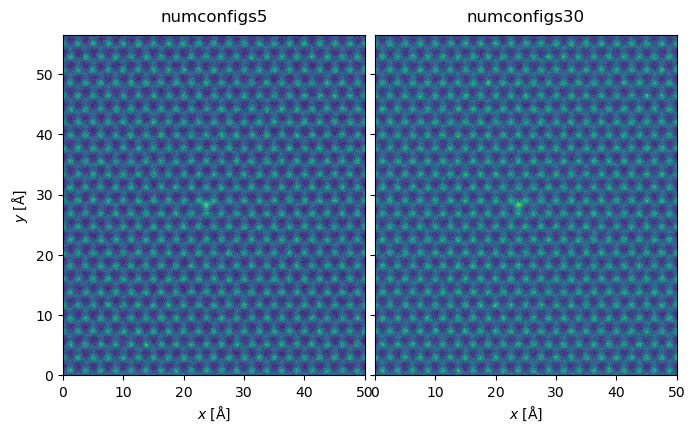

In [33]:
noisy_measurements_plot = abtem.stack(noisy_measurements, parameter_info)
noisy_measurements_plot[::5].show(explode=True, figsize=(12, 4))
